In [1]:
import math as m
import warnings
import matplotlib.pyplot as plt

In [2]:
def meshgrid(x, y):
    len_x = len(x)
    len_y = len(y)
    grid_x = [x[:] for j in range(len_y)]
    grid_y = [[y[j]] * len_x for j in range(len_y)]
    return [grid_x, grid_y]

In [3]:
def transform_grid(grid_x, grid_y, transformation):
    n = len(grid_x)
    m = len(grid_x[0])
    z = []
    for i in range(n):
        z_row = []
        for j in range(m):
            z_row.append(transformation(grid_x[i][j], grid_y[i][j]))
        z.append(z_row)
    return z

In [4]:
def points_from_segment(a, b, N_of_points):
    assert a < b
    N = N_of_points-1
    return [a * (1 - j/N) + b * (j/N) for j in range(N+1)]

In [5]:
def euclid_norm(x, y):
    return (x*x + y*y) ** 0.5

In [6]:
class GradDescent2D:
    def __init__(self, f, grad_f, alpha=1):
        self._f = f
        self._grad_f = grad_f
        self._alpha = alpha
        self._direction = None
        
    def _calc_direction(self, x, y):
        grad_val = self._grad_f(x, y)
        grad_norm = euclid_norm(grad_val[0], grad_val[1])
        d_x = (-1) * grad_val[0]/grad_norm
        d_y = (-1) * grad_val[1]/grad_norm
        self._direction = [d_x, d_y]
        
    def _distance(self, x_prev, y_prev, x_next, y_next, delta):
        delta_x = x_prev - x_next
        delta_y = y_prev - y_next
        dist = euclid_norm(delta_x, delta_y)
        if m.isinf(dist):
            warnings.warn("Algorithm did not converge, distance is inf")
        print([dist, delta])
        return dist >= delta
    
    def _increment(self, x_prev, y_prev, x_next, y_next, epsilon):
        f_prev = self._f(x_prev, y_prev)
        f_next = self._f(x_next, y_next)
        incr = abs(f_prev - f_next)
        if m.isinf(incr):
            warnings.warn("Algorithm did not converge, increment is inf")
        print([incr, epsilon * abs(f_prev)])
        return incr >= epsilon * abs(f_prev)
    
    def _gamma_proportional(self, x_prev, y_prev):
        return self._alpha * euclid_norm(*self._grad_f(x_prev, y_prev))
    
    def _gamma_optimal(self, x_prev, y_prev):
        pass
    
    def _next(self, x_prev, y_prev, gamma_method):
        self._calc_direction(x_prev, y_prev)
        current_gamma = getattr(self, gamma_method)(x_prev, y_prev)
            
        x_next = x_prev + current_gamma * self._direction[0]
        y_next = y_prev + current_gamma * self._direction[1]
        
        return [x_next, y_next]
        
    def do_descent(self, x0, y0, 
                   gamma_method, check_method, precision, max_iter=1000,
                   make_plot=False, xlim=None, ylim=None, N=None):
        assert precision > 0
        
        chosen_gamma_method = "_gamma_" + gamma_method
        chosen_check_method = "_" + check_method
        
        assert chosen_gamma_method in dir(self)
        assert chosen_check_method in dir(self)
        
        if make_plot:
            xdots = [x0]
            ydots = [y0]
        
        x_prev, y_prev = x0, y0
        x_next, y_next = self._next(x_prev, y_prev, chosen_gamma_method)
        
        n_iter = 1
        
        while getattr(self, chosen_check_method)(x_prev, y_prev, x_next, y_next, precision):
            if n_iter > max_iter:
                warnings.warn("Algorithm did not converge for given MAX_ITER = %i" % max_iter)
                break
            
            x_prev, y_prev = x_next, y_next
            x_next, y_next = self._next(x_prev, y_prev, chosen_gamma_method)
            
            if make_plot:
                xdots.append(x_prev)
                ydots.append(y_prev)
            
            n_iter += 1
        
        self._direction = None
        
        if make_plot:
            xdots.append(x_next)
            ydots.append(y_next)
                        
            x_linspace = points_from_segment(*xlim, N)
            y_linspace = points_from_segment(*ylim, N)
        
            meshgrid_xy = meshgrid(x_linspace, y_linspace)
            grid_z = transform_grid(*meshgrid_xy, self._f)
            
            fig, ax = plt.subplots()
            
            ax.set_xlim(xlim)
            ax.set_ylim(ylim)
            ax.grid()

            contour_set = ax.contour(*meshgrid_xy, grid_z)
            ax.clabel(contour_set, inline=True, fontsize=8)
            
            print("Finished")
            
            for i in range(1,len(xdots)):
                ax.plot([xdots[i-1], xdots[i]], [ydots[i-1], ydots[i]], 
                         marker='o', markersize=2.5, color='red')
        
            plt.axis('equal')
            plt.show()
        
        print("Algorithm finished after %i iterations" % n_iter)
        return [x_next, y_next]
    
    def set_alpha(self, alpha):
        self._alpha = alpha
        
    def get_alpha(self):
        return self._alpha

In [7]:
def h(x,y):
    return m.exp(y*y - x*x) + x*x + m.sin(3*x + y)/(1 + x*x)

$h(x,y) = e^{y^2-x^2} + x^2 + \dfrac{\sin(3x + y)}{1 + x^2}$

$K = [-2,0]\times[-1,-0.25]$

$(e^{y^2-x^2})_x^{'} = (-2) \cdot x \cdot e^{y^2-x^2}$

$(e^{y^2-x^2})_y^{'} = 2 \cdot y \cdot e^{y^2-x^2}$

$(x^2)_x^{'} = 2x$

$(x^2)_y^{'} = 0$

$\left(\dfrac{\sin(3x + y)}{1 + x^2}\right)_x^{'} = \dfrac{3\cdot(1+x^2)\cdot\cos(3x+y)-2\cdot x\cdot\sin(3x+y)}{(1+x^2)^2}$

$\left(\dfrac{\sin(3x + y)}{1 + x^2}\right)_y^{'} = \dfrac{\cos(3x+y)}{1+x^2}$

$\dfrac{\partial h(x,y)}{\partial x} = (e^{y^2-x^2})_x^{'} + (x^2)_x^{'} + \left(\dfrac{\sin(3x + y)}{1 + x^2}\right)_x^{'} = (-2) \cdot x \cdot e^{y^2-x^2} + 2x + \dfrac{3\cdot(1+x^2)\cdot\cos(3x+y)-2\cdot x\cdot\sin(3x+y)}{(1+x^2)^2}$

$\dfrac{\partial h(x,y)}{\partial y} = 2 \cdot y \cdot e^{y^2-x^2} + \dfrac{\cos(3x+y)}{1+x^2}$

Звідси $\nabla h(x,y) = \left(\dfrac{\partial h(x,y)}{\partial x}, \dfrac{\partial h(x,y)}{\partial y}\right) = \left((-2) \cdot x \cdot e^{y^2-x^2} + 2x + \dfrac{3\cdot(1+x^2)\cdot\cos(3x+y)-2\cdot x\cdot\sin(3x+y)}{(1+x^2)^2}, 2 \cdot y \cdot e^{y^2-x^2} + \dfrac{\cos(3x+y)}{1+x^2}\right)$

In [8]:
def grad_h(x,y):
    return [
        (-2)*x*m.exp(y*y - x*x) + 2*x + (3 * (1 + x*x) * m.cos(3*x + y) - 2 * x * m.sin(3*x + y))/((1 + x*x) ** 2),
        2*y*m.exp(y*y - x*x) + m.cos(3*x + y)/(1+x*x)
    ]

Чи є $h(x,y)$ опуклою на всьому $K$? Взагалі кажучи, ні.

In [9]:
N = 1000
Klimx = points_from_segment(-2, 0, N)
Klimy = points_from_segment(-1, -0.25, N)
Kxy = meshgrid(Klimx, Klimy)

In [10]:
Hxy = transform_grid(*Kxy, h)

<a list of 14 text.Text objects>

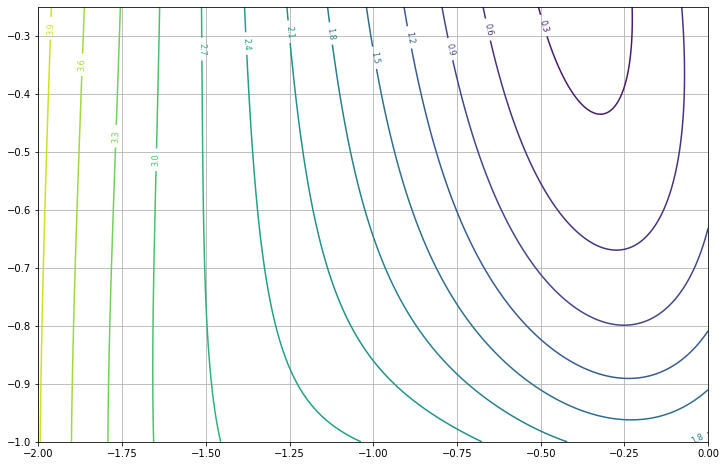

In [11]:
plt.rcParams['figure.figsize'] = [12, 8]
fig, ax = plt.subplots()
            
ax.set_xlim([Klimx[0], Klimx[-1]])
ax.set_ylim([Klimy[0], Klimy[-1]])
ax.grid()

contour_set = ax.contour(*Kxy, Hxy, 12)
ax.clabel(contour_set, inline=True, fontsize=8)

(-2.0, 0.0)

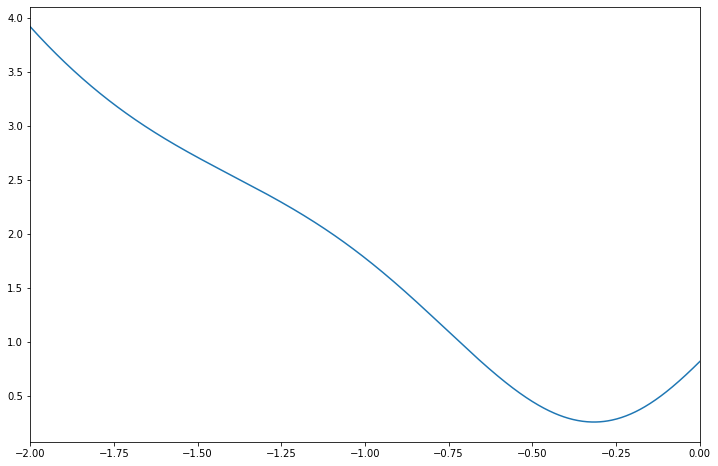

In [12]:
plt.plot(Klimx, [h(Klimx[i], Klimy[i]) for i in range(N)])
plt.xlim([-2,0])

(-1.0, -0.25)

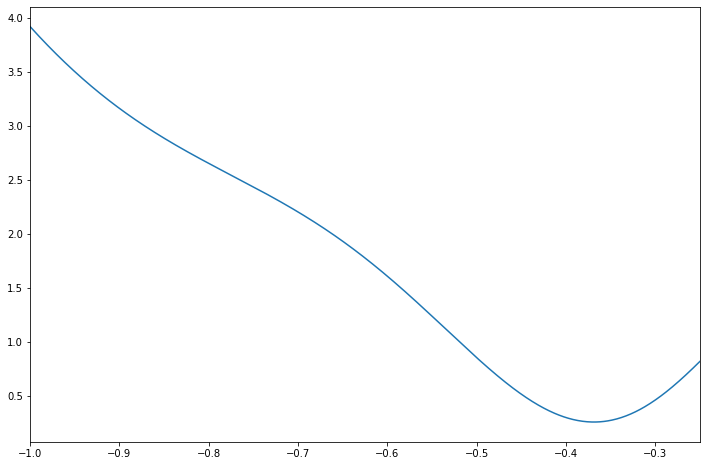

In [13]:
plt.plot(Klimy, [h(Klimx[i], Klimy[i]) for i in range(N)])
plt.xlim([-1,-0.25])

In [14]:
grad_test_h = GradDescent2D(h, grad_h, alpha=0.07)

[0.16824163275406154, 0.0004]
[0.15937860141300167, 0.0004]
[0.18253802453063128, 0.0004]
[0.1958696317010779, 0.0004]
[0.16150704152556325, 0.0004]
[0.08551374491791987, 0.0004]
[0.03873129924449036, 0.0004]
[0.025920109063048136, 0.0004]
[0.021072297636344498, 0.0004]
[0.017685883799821767, 0.0004]
[0.014963308144986991, 0.0004]
[0.01272020484194042, 0.0004]
[0.010853140721363981, 0.0004]
[0.009287630403647983, 0.0004]
[0.007967263061044562, 0.0004]
[0.006848329905778912, 0.0004]
[0.0058963753390775565, 0.0004]
[0.005083846213057656, 0.0004]
[0.004388441388592674, 0.0004]
[0.0037919251469446164, 0.0004]
[0.0032792560960955173, 0.0004]
[0.002837935659562184, 0.0004]
[0.0024575125932480776, 0.0004]
[0.0021292004780502, 0.0004]
[0.0018455784338680494, 0.0004]
[0.0016003541102323604, 0.0004]
[0.0013881739586045789, 0.0004]
[0.0012044698816482788, 0.0004]
[0.0010453342130423357, 0.0004]
[0.0009074170093645574, 0.0004]
[0.000787841094986823, 0.0004]
[0.0006841313652504882, 0.0004]
[0.00059

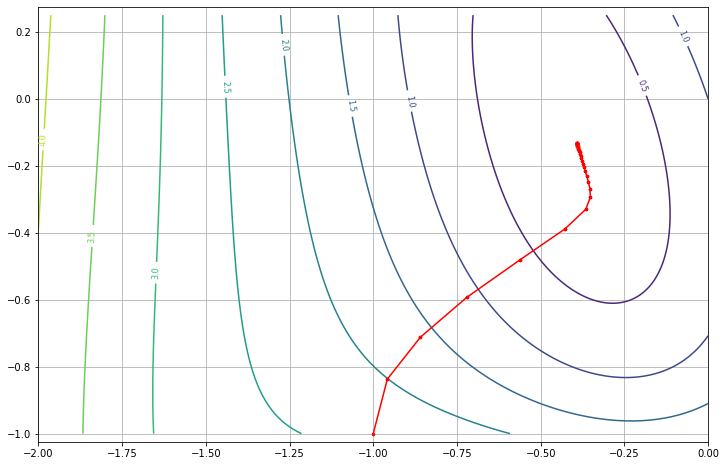

Algorithm finished after 36 iterations
[-0.3927868010146399, -0.13104207336848786]


In [15]:
pres11 = grad_test_h.do_descent(x0=-1, y0=-1, 
                         gamma_method="proportional", 
                         check_method="distance", 
                         precision=4*(10**(-4)), max_iter=10e16,
                         make_plot=True, xlim=[-2,0], ylim=[-1,0.25], N=1000)
print(pres11)

[0.37472336797331307, 7.1352037429618924e-06]
[0.3872348390784075, 6.011033639041954e-06]
[0.4995510686345399, 4.849329121806731e-06]
[0.5146721068800283, 3.350675915903111e-06]
[0.29187817889467393, 1.8066595952630265e-06]
[0.07415956893054432, 9.310250585790045e-07]
[0.017251988629029436, 7.085463517873716e-07]
[0.008640045409830654, 6.567903859002833e-07]
[0.005827316644472447, 6.308702496707914e-07]
[0.004122677937069663, 6.13388299737374e-07]
[0.0029579036172673323, 6.01020265926165e-07]
[0.002141303039008502, 5.921465550743629e-07]
[0.001561041475370395, 5.857226459573375e-07]
[0.0011444999851256688, 5.810395215312263e-07]
[0.0008430226258517859, 5.776060215758493e-07]
[0.0006233551052780006, 5.750769536982939e-07]
[0.0004624080796821195, 5.732068883824599e-07]
[0.0003439403593533674, 5.718196641434136e-07]
[0.0002564037868781899, 5.707878430653535e-07]
[0.0001915127416636242, 5.700186317047189e-07]
[0.00014327724002771713, 5.69444093479728e-07]
[0.00010733917888394728, 5.6901426

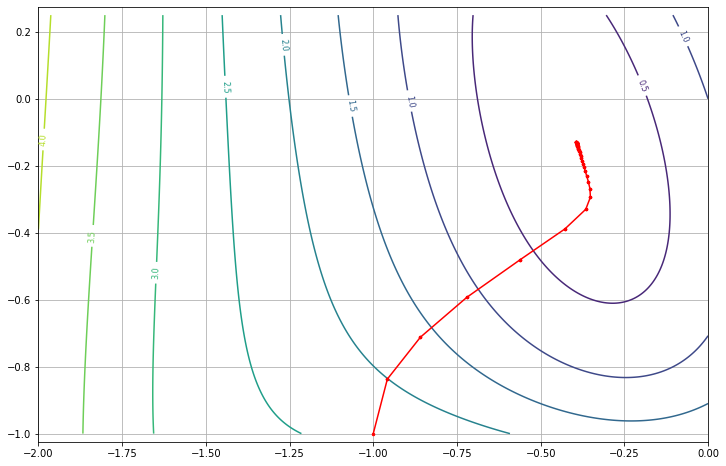

Algorithm finished after 41 iterations
[-0.39317122953059325, -0.12979731889882554]


In [16]:
pres12 = grad_test_h.do_descent(x0=-1, y0=-1, 
                         gamma_method="proportional", 
                         check_method="increment", 
                         precision=3*(10**(-6)), max_iter=10e16,
                         make_plot=True, xlim=[-2,0], ylim=[-1,0.25], N=1000)
print(pres12)

In [17]:
grad_test_h.set_alpha(0.01)

[0.02403451896486586, 0.0004]
[0.023494953609501757, 0.0004]
[0.023189275620117904, 0.0004]
[0.023072626553963093, 0.0004]
[0.02311007646076427, 0.0004]
[0.023273671074245782, 0.0004]
[0.023540342383457636, 0.0004]
[0.02389035868457592, 0.0004]
[0.024306128328687438, 0.0004]
[0.024771249179229262, 0.0004]
[0.025269742559243896, 0.0004]
[0.025785441258230575, 0.0004]
[0.02630152362907342, 0.0004]
[0.026800203444558985, 0.0004]
[0.027262598921686077, 0.0004]
[0.027668813234712347, 0.0004]
[0.027998260609016435, 0.0004]
[0.028230263581995277, 0.0004]
[0.02834492527267604, 0.0004]
[0.028324244296520876, 0.0004]
[0.028153391772274983, 0.0004]
[0.027822017532387614, 0.0004]
[0.02732540956376869, 0.0004]
[0.02666531333324711, 0.0004]
[0.025850240004857333, 0.0004]
[0.024895159166504966, 0.0004]
[0.023820572476332076, 0.0004]
[0.0226510754766483, 0.0004]
[0.021413605125915364, 0.0004]
[0.020135615208179337, 0.0004]
[0.01884341104573643, 0.0004]
[0.01756081763210676, 0.0004]
[0.0163082732066763

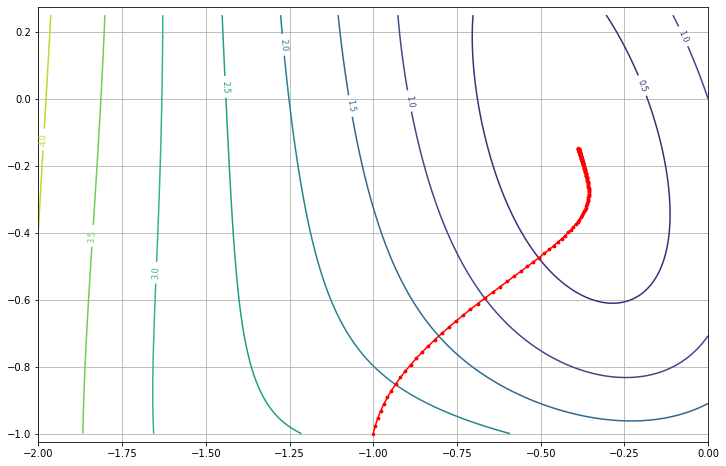

Algorithm finished after 161 iterations
[-0.3875453441458068, -0.14804451389777507]


In [18]:
pres21 = grad_test_h.do_descent(x0=-1, y0=-1, 
                         gamma_method="proportional", 
                         check_method="distance", 
                         precision=4*(10**(-4)), max_iter=10e16,
                         make_plot=True, xlim=[-2,0], ylim=[-1,0.25], N=1000)
print(pres21)

[0.05704916705240848, 7.1352037429618924e-06]
[0.054785772589923454, 6.964056241804668e-06]
[0.05359208877385768, 6.799698924034897e-06]
[0.05323873258581946, 6.638922657713324e-06]
[0.05356411485536716, 6.479206459955865e-06]
[0.054449907582815094, 6.318514115389764e-06]
[0.05580500206064354, 6.155164392641319e-06]
[0.05755442954064005, 5.987749386459388e-06]
[0.05963125680724679, 5.815086097837468e-06]
[0.061970327805526804, 5.636192327415727e-06]
[0.06450323957908899, 5.450281343999147e-06]
[0.0671542848663238, 5.256771625261881e-06]
[0.069837349098677, 5.055308770662909e-06]
[0.07245395362265739, 4.845796723366878e-06]
[0.07489279573029917, 4.628434862498906e-06]
[0.07703123076136364, 4.403756475308008e-06]
[0.07873913396332499, 4.172662783023917e-06]
[0.0798854225590282, 3.9364453811339425e-06]
[0.0803471743946611, 3.6967891134568575e-06]
[0.08002075087540028, 3.4557475902728745e-06]
[0.07883369190881573, 3.2156853376466737e-06]
[0.07675556000822925, 2.979184261920226e-06]
[0.0738

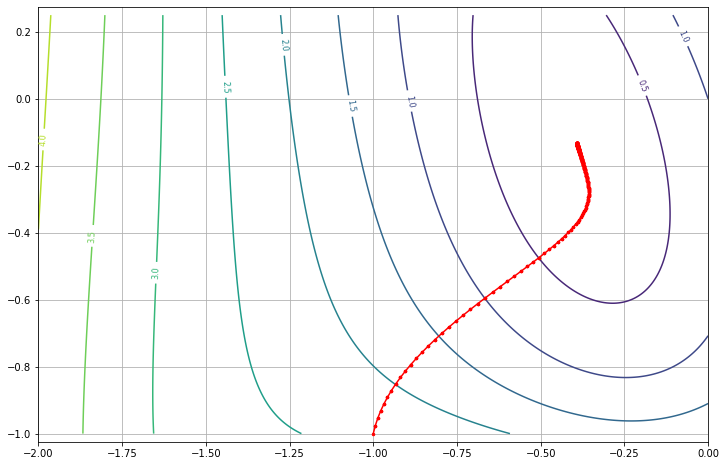

Algorithm finished after 248 iterations
[-0.3923953094585262, -0.13231006763136555]


In [19]:
pres22 = grad_test_h.do_descent(x0=-1, y0=-1, 
                         gamma_method="proportional", 
                         check_method="increment", 
                         precision=3*(10**(-6)), max_iter=10e16,
                         make_plot=True, xlim=[-2,0], ylim=[-1,0.25], N=1000)
print(pres22)